In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
#from tensorflow.keras.layers import *
#from tensorflow.keras.models import *
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K 

# Helper libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


# From the tutorial
# https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/
#from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold

from datetime import datetime
from packaging import version

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."


def s(x):
    
    "Activation function to implement the basis functions"
    
    y0 = K.switch(tf.logical_and(tf.zeros(tf.shape(x))<=x, x<tf.ones(tf.shape(x))), 
                 x**3/6, 
                 tf.zeros(tf.shape(x))
                )
    
    y1 = K.switch(tf.logical_and(tf.ones(tf.shape(x))<=x, x<2*tf.ones(tf.shape(x))),
                 (-3.*(x-1.)**3 +3.*(x-1.)**2 + 3*(x-1.)+1.)/6.,
                 tf.zeros(tf.shape(x))
                )
    
    y2 = K.switch(tf.logical_and(tf.ones(tf.shape(x))*2<=x, x<3*tf.ones(tf.shape(x))),
                 (3*(x-2)**3 - 6*(x-2)**2 + 4. )/6.,
                 tf.zeros(tf.shape(x))
                )

    y3 = K.switch(tf.logical_and(tf.ones(tf.shape(x))*3<=x, x<4*tf.ones(tf.shape(x))),
                 ( 4. -x)**3/6.,
                 tf.zeros(tf.shape(x))
                )    
    
    y  = y0 + y1 + y2 + y3
    
    return y


def partition_weights(n,n0):
    p0 = n0*n
    y = np.zeros((n,p0))
    for i in range(n):
        y[i,i*n0:(i+1)*n0] = 1.
    return y 

def partition_bias(n,n0):
    p0 = n0*n
    return (np.arange(0.,p0)%n0)    

def spline_function_(n,m,c0,u0):
    """
    Function from [0,1]^n to R^m
    n  - Input dimension
    m  - output dimension
    c0 - the capacity of the network, the number of control points for each input variable is proportional capacity
    u0 - the initial value of all control points
    """
    
    d0 = 3 
 
    n0 = c0 + d0 # the number of control points; capacity + degree of basis function
    p0 = n0*n

    w0 = tf.constant_initializer(c0*partition_weights(n,n0))
    b0 = tf.constant_initializer(d0 - partition_bias(n,n0))
    
    w1 = tf.constant_initializer(u0)

    inn = tf.keras.layers.Input(shape=(n,))

    l00 = tf.keras.layers.Dense(activation=s3,
                                units=p0,
                                use_bias=True,
                                trainable=False,
                                kernel_initializer=w0,
                                bias_initializer=b0 
                               )(inn)          # Modified
    
    out = tf.keras.layers.Dense(units=m,
                                use_bias=False,
                                trainable=True,
                                kernel_initializer=w1
                               )(l00)

    model = tf.keras.Model(inputs=inn, 
                           outputs= out
                          )
    return model

def partition_weights_2(n,r):
    d0 = float(3)
    l0 = 4*(2**np.arange(0,r))
    l1 = [(x-d0)*partition_weights(n,x) for x in l0]
    l2 = np.concatenate(l1,axis=1)
    return l2

def partition_bias_2(n,r):
    d0 = float(3)
    l0 = 4*(2**np.arange(0,r))
    l1 = [d0 - partition_bias(n,x) for x in l0]
    l2 = np.concatenate(l1,axis=0)
    return l2


TensorFlow version:  2.1.0


In [2]:
class Memory_Regularizer(tf.keras.regularizers.Regularizer):
    
    def __init__(self, h0=0.,weight_memory = 0.):
        self.h0 = h0
        self.weight_memory = weight_memory
        
    def __call__(self, x):
        #self.l2 * tf.math.reduce_sum(tf.math.square(x))
        #self.h0 * tf.math.reduce_sum(tf.math.abs(x-self.weight_memory))
        return self.h0 * tf.math.reduce_sum(tf.math.square(x-self.weight_memory))
    
    def get_config(self):
        
        return {'h0': float(self.h0)}

In [3]:
class typical_ann(keras.Model):
    """ """
    def __init__(self, n, m, r, k, h):
        super(typical_ann, self).__init__()
        
        #tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
        #tf.constant_initializer(0.)
        
        self.n = n
        self.m = m
        self.r = r
        self.k = k
        #self.h = h
        
        self.memory_regulizer_f11 = Memory_Regularizer(h0=h,weight_memory=0.)
        self.memory_regulizer_f02 = Memory_Regularizer(h0=h,weight_memory=0.)
        self.memory_regulizer_f55 = Memory_Regularizer(h0=h,weight_memory=0.)
        
        
        self.f01 = tf.keras.layers.Dense(activation=s,
                                     name='OSAM_P0',
                                     units=n*((4*(2**np.arange(0,r))).sum()),
                                     use_bias=True,
                                     trainable=True)
        
        self.f11 = tf.keras.layers.Dense(units=m,
                                     name='OSAM_F0',
                                     use_bias=False,
                                     trainable=True)
        
        self.f02 = tf.keras.layers.Dense(activation=None,
                                         name='Inner_Functions',
                                         units=k,
                                         use_bias=False,
                                         trainable=True)
        
        self.f22 = tf.keras.layers.Dense(activation=None,
                                         name='Projected_Inner_Res',
                                         units=m,
                                         use_bias=False,
                                         trainable=True)
        
        self.f03 = tf.keras.layers.Activation(tf.nn.sigmoid,name='Sigmoid')
        
        self.f04 = tf.keras.layers.Dense(activation=s,
                                         name='Outer_OSAM_P0',
                                         units=k*((4*(2**np.arange(0,r))).sum()),
                                         use_bias=True,
                                         trainable=True)
        
        
        self.f55 = tf.keras.layers.Dense(units=m,
                                         name='Outer_OSAM_F0',
                                         use_bias=False,
                                         trainable=True)
        
        self.out = tf.keras.layers.Add(name='Model_Output')
        
    def call(self, input_tensor, training=False):
        
        f01 = self.f01(input_tensor)
        f11 = self.f11(f01)
        
        f02 = self.f02(f01)
        f22 = self.f22(f02)
        
        f03 = self.f03(f02)
        f04 = self.f04(f03)
        f55 = self.f55(f04)
        
        out = self.out([f11,f22,f55])
        return out
                
    def construct(self):
        """
        Use explicit construct method so that summary method displays the correct output shape of each layer
        Otherwise it just says multiple which is useless information 
        """
        self(tf.keras.layers.Input(shape=(self.n,)))
        
    def memory_update(self):
        
        self.memory_regulizer_f11.weight_memory = tf.constant(self.f11.get_weights())
        self.memory_regulizer_f02.weight_memory = tf.constant(self.f02.get_weights())
        self.memory_regulizer_f55.weight_memory = tf.constant(self.f55.get_weights())
        

In [4]:
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

import tensorboard
print(tensorboard.__version__)

#Load the TensorBoard notebook extension.
%load_ext tensorboard

TensorFlow version:  2.1.0
2.6.0


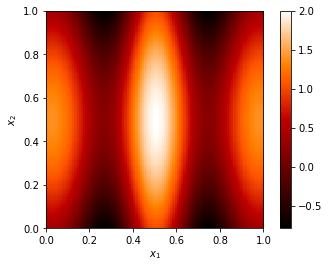

In [5]:
# Target function plot

def f(x,y):
    v0 = np.cos(4.*np.pi*x)*np.exp(-4*(x-0.5)**2) + np.sin(1.*np.pi*y)
    return v0

def f2(x,y):
    
    l0 = np.ones(x.shape)
    l1 = np.logical_and((x < 0.55*l0),(0.45*l0 < x ))
    l2 = np.logical_and((y < 0.55*l0),(0.45*l0 < y ))
    l3 = np.logical_and(l1,l2)
    
    v0 = f(x,y)*np.logical_not(l3) + 0.*l3
    
    return v0

resolution = 0.01

x0 = np.arange(0.,1., resolution)
x1 = np.arange(0.,1., resolution)

x0, x1 = np.meshgrid(x0, x1)
y0 = f(x0,x1)

img = plt.imshow(y0, interpolation='none', extent=[0.,1.,0.,1.])
#img.set_cmap('hot')
img.set_cmap('gist_heat')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()

coordinates = np.array([x0.flatten(),x1.flatten()]).transpose()

2022-04-06 17:50:25.036702: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-04-06 17:50:25.058090: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2799925000 Hz
2022-04-06 17:50:25.058481: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55b8b9b4fe10 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-06 17:50:25.058504: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-04-06 17:50:25.058599: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "typical_ann"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
OSAM_P0 (Dense)              (None, 120)               360       
_________________________________________________________________
OSAM_F0 (Dense)              (None, 1)                 120       
_________________________________________________________________
Inner_Functions (Dense)      (None, 3)                 360       
_________________________________________________________________
Projected_Inner_Res (Dense)  (None, 1)                 3         
_________________________________________________________________
Sigmoid (Activation)         (None, 3)                 0         
_________________________________________________________________
Outer_OSAM_P0 (Dense)        (None, 180)               720       
_________________________________________________________________
Outer_OSAM_F0 (Dense)        (None, 1)                 

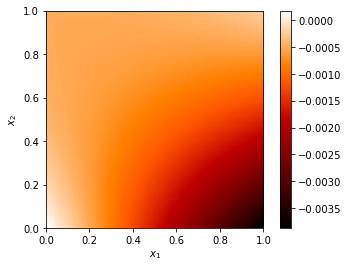

In [6]:
# Initialise a model
# n,m,r,k,u0,h0
n   = 2
m   = 1
r   = 4
k   = 3
h   = 0.

model = typical_ann(n,m,r,k,h)

model.construct()


# Print model summary
model.summary()

# Adjust weights for testing purposes, comment out otherwise
#weights = model.get_weights()



# Change index value to inspect the model
#index = 73 #change this value
#weights[2][index] = 1.
#model.set_weights(weights)


output1 = model.predict(coordinates).reshape(100,100)

img = plt.imshow(output1, interpolation='none', extent=[0.,1.,0.,1.])
img.set_cmap('hot')
img.set_cmap('gist_heat')
#img.set_cmap('summer')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()

Model: "typical_ann_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
OSAM_P0 (Dense)              (None, 120)               360       
_________________________________________________________________
OSAM_F0 (Dense)              (None, 1)                 120       
_________________________________________________________________
Inner_Functions (Dense)      (None, 3)                 360       
_________________________________________________________________
Projected_Inner_Res (Dense)  (None, 1)                 3         
_________________________________________________________________
Sigmoid (Activation)         (None, 3)                 0         
_________________________________________________________________
Outer_OSAM_P0 (Dense)        (None, 180)               720       
_________________________________________________________________
Outer_OSAM_F0 (Dense)        (None, 1)               

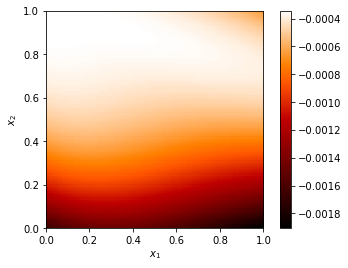

Train on 10000 samples
Epoch 1/15
10000/10000 [==============================] - 4s 366us/sample - loss: 0.5083 - mse: 0.5083
Epoch 2/15
10000/10000 [==============================] - 2s 226us/sample - loss: 0.3561 - mse: 0.3561
Epoch 3/15
10000/10000 [==============================] - 2s 197us/sample - loss: 0.3180 - mse: 0.3180
Epoch 4/15
10000/10000 [==============================] - 2s 195us/sample - loss: 0.3068 - mse: 0.3068
Epoch 5/15
10000/10000 [==============================] - 2s 215us/sample - loss: 0.3044 - mse: 0.3044
Epoch 6/15
10000/10000 [==============================] - 2s 189us/sample - loss: 0.2979 - mse: 0.2979
Epoch 7/15
10000/10000 [==============================] - 2s 232us/sample - loss: 0.2923 - mse: 0.2923
Epoch 8/15
10000/10000 [==============================] - 2s 224us/sample - loss: 0.2892 - mse: 0.2892
Epoch 9/15
10000/10000 [==============================] - 2s 211us/sample - loss: 0.2877 - mse: 0.2877
Epoch 10/15
10000/10000 [=========================

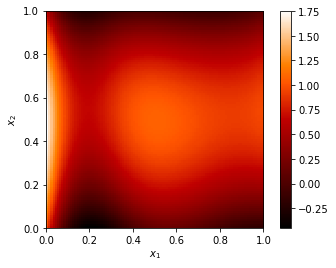

10000/10000 [==============================] - 1s 140us/sample - loss: 0.2304 - mse: 0.2304


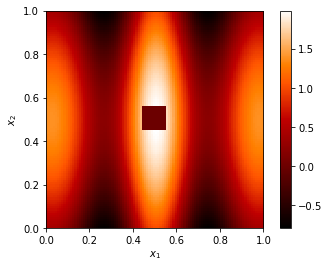

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 2s 191us/sample - loss: 0.0235 - mse: 0.0235
Epoch 2/10
10000/10000 [==============================] - 2s 215us/sample - loss: 6.1441e-05 - mse: 6.1441e-05
Epoch 3/10
10000/10000 [==============================] - 2s 232us/sample - loss: 5.1565e-05 - mse: 5.1565e-05
Epoch 4/10
10000/10000 [==============================] - 2s 206us/sample - loss: 4.6215e-05 - mse: 4.6215e-05
Epoch 5/10
10000/10000 [==============================] - 2s 198us/sample - loss: 4.3618e-05 - mse: 4.3618e-05
Epoch 6/10
10000/10000 [==============================] - 2s 215us/sample - loss: 4.2547e-05 - mse: 4.2547e-05
Epoch 7/10
10000/10000 [==============================] - 2s 249us/sample - loss: 4.1989e-05 - mse: 4.1989e-05
Epoch 8/10
10000/10000 [==============================] - 2s 218us/sample - loss: 4.1609e-05 - mse: 4.1609e-05
Epoch 9/10
10000/10000 [==============================] - 2s 211us/sample - loss: 4.1489e-05 - ms

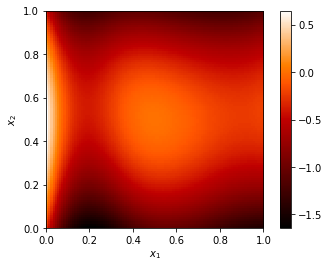

In [7]:
# Initialise a model

##################################################################################
# Initialise a model
# n,m,r,k,u0,h0
n   = 2
m   = 1
r   = 4
k   = 3
h   = 0.

model = typical_ann(n,m,r,k,h)

model.construct()

model.summary()
##################################################################################

output1 = model.predict(coordinates).reshape(100,100)

##################################################################################
img = plt.imshow(output1, interpolation='none', extent=[0.,1.,0.,1.])
img.set_cmap('hot')
img.set_cmap('gist_heat')
#img.set_cmap('summer')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()
##################################################################################

#########
#########
#########

# Data Generation 
##################################################################################
k = 10000

train_inputs = np.random.rand(k,2)
z0 = train_inputs[:,0]
z1 = train_inputs[:,1]
train_output = f(z0,z1)
##################################################################################

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.mean_squared_error,metrics=['mse'])

model.fit(train_inputs, train_output, epochs=15,verbose=1)

output2 = model.predict(coordinates).reshape(100,100)

##################################################################################
img = plt.imshow(output2, interpolation='none', extent=[0.,1.,0.,1.])
img.set_cmap('hot')
img.set_cmap('gist_heat')
#img.set_cmap('summer')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()
##################################################################################

# Test on second task
##################################################################################
x_test1 = np.random.rand(k,2)
y_test1 = f(x_test1[:,0],x_test1[:,1])
results1 = model.evaluate(x_test1, y_test1)
##################################################################################

##########################
########################

##################################################################################

y_new = y0.copy()
y_new[44:55,44:55] = 0.

img = plt.imshow(y_new, interpolation='none', extent=[0.,1.,0.,1.])
#img.set_cmap('hot')
img.set_cmap('gist_heat')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()

##################################################################################

train_inputs_2 = 0.11*np.random.rand(k,2)+0.44
train_output_2 = np.ones(k)*0.
model.fit(train_inputs_2, train_output_2, epochs=10,verbose=1)

##################################################################################

# Test on second task
##################################################################################
x_test2 = np.random.rand(k,2)
y_test2 = f2(x_test2[:,0],x_test2[:,1])
results2 = model.evaluate(x_test2, y_test2)
##################################################################################

output3 = model.predict(coordinates).reshape(100,100)

##################################################################################
img = plt.imshow(output3, interpolation='none', extent=[0.,1.,0.,1.])
img.set_cmap('hot')
img.set_cmap('gist_heat')
#img.set_cmap('summer')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()
##################################################################################

In [8]:
task_1_results = []
task_2_results = []

for i in range(0,30):
    # Initialise a model

    # Initialise a model
    # n,m,r,k,u0,h0
    n   = 2
    m   = 1
    r   = 4
    k   = 3
    h   = 0.

    model = typical_ann(n,m,r,k,h)

    model.construct()

    output1 = model.predict(coordinates).reshape(100,100)

    # Data Generation 
    ##################################################################################
    k = 10000

    train_inputs = np.random.rand(k,2)
    z0 = train_inputs[:,0]
    z1 = train_inputs[:,1]
    train_output = f(z0,z1)

    ##################################################################################

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                  loss=tf.keras.losses.mean_squared_error,metrics=['mse'])

    model.fit(train_inputs, train_output, epochs=50,verbose=0)

    output2 = model.predict(coordinates).reshape(100,100)

    # Test on second task
    ##################################################################################
    x_test1 = np.random.rand(k,2)
    y_test1 = f(x_test1[:,0],x_test1[:,1])
    print("eval")
    results1 = model.evaluate(x_test1, y_test1)

    task_1_results.append(results1[-1])
    ##################################################################################

    y_new = y0.copy()
    y_new[44:55,44:55] = 0.

    ##################################################################################

    train_inputs_2 = 0.11*np.random.rand(k,2)+0.44
    train_output_2 = np.ones(k)*0.
    model.fit(train_inputs_2, train_output_2, epochs=10,verbose=0)

    ##################################################################################

    # Test on second task
    ##################################################################################
    x_test2 = np.random.rand(k,2)
    y_test2 = f2(x_test2[:,0],x_test2[:,1])
    print("evaluation")
    results2 = model.evaluate(x_test2, y_test2)

    task_2_results.append(results2[-1])
    ##################################################################################

    output3 = model.predict(coordinates).reshape(100,100)

    ##################################################################################

eval
10000/10000 [==============================] - 2s 152us/sample - loss: 0.1782 - mse: 0.1782
evaluation
10000/10000 [==============================] - 1s 142us/sample - loss: 1.3949 - mse: 1.3949
eval
10000/10000 [==============================] - 2s 176us/sample - loss: 0.0510 - mse: 0.0510
evaluation
10000/10000 [==============================] - 1s 130us/sample - loss: 1.8132 - mse: 1.8132
eval
10000/10000 [==============================] - 2s 173us/sample - loss: 0.1684 - mse: 0.1684
evaluation
10000/10000 [==============================] - 1s 123us/sample - loss: 1.7521 - mse: 1.7521
eval
10000/10000 [==============================] - 1s 135us/sample - loss: 0.0522 - mse: 0.0522
evaluation
10000/10000 [==============================] - 1s 109us/sample - loss: 1.8211 - mse: 1.8211
eval
10000/10000 [==============================] - 2s 152us/sample - loss: 0.0482 - mse: 0.0482
evaluation
10000/10000 [==============================] - 1s 96us/sample - loss: 1.8773 - mse: 1.8773
e

In [9]:
task_1_results

[0.17818792,
 0.050972484,
 0.16843262,
 0.052211236,
 0.04823687,
 0.10719182,
 0.051374353,
 0.051005524,
 0.08580743,
 0.04839996,
 0.10044019,
 0.072028324,
 0.058259837,
 0.047809016,
 0.04581412,
 0.053768914,
 0.050994188,
 0.047067747,
 0.11078267,
 0.040102378,
 0.07381616,
 0.020062387,
 0.049917664,
 0.048068658,
 0.050475255,
 0.053443816,
 0.05096414,
 0.055185445,
 0.055910565,
 0.051928412]

In [10]:
task_2_results

[1.3949268,
 1.8131639,
 1.7520955,
 1.8211473,
 1.8772861,
 1.7993354,
 1.4237252,
 1.8048481,
 1.7287956,
 1.8299481,
 2.0867202,
 2.1538699,
 1.7910221,
 1.3206125,
 1.718221,
 1.8515934,
 1.898608,
 1.3850155,
 1.5159676,
 1.8115213,
 2.5921237,
 1.2995603,
 1.7041013,
 1.543009,
 1.7563721,
 1.6253605,
 1.3475567,
 1.6611465,
 1.8736264,
 2.0377672]

In [17]:
np.array(task_1_results).mean()

0.06595533

In [18]:
np.array(task_1_results).std()

0.034578793

In [19]:
np.array(task_2_results).mean()

1.7406349

In [20]:
np.array(task_2_results).std()

0.27053773